# Portland Trail Blazers - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 20, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [2]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [ ]:
lkupclientid = 5 # blazers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27478 entries, 0 to 27477
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              27478 non-null  int64  
 1   dimCustomerMasterId       27478 non-null  int64  
 2   customerNumber            27478 non-null  object 
 3   year                      27478 non-null  int64  
 4   productGrouping           27478 non-null  object 
 5   totalSpent                27478 non-null  float64
 6   recentDate                27478 non-null  object 
 7   attendancePercent         27478 non-null  float64
 8   renewedBeforeDays         27478 non-null  int64  
 9   isBuyer                   27478 non-null  object 
 10  source_tenure             27478 non-null  int64  
 11  tenure                    27478 non-null  int64  
 12  distToVenue               0 non-null      object 
 13  totalGames                27478 non-null  int64  
 14  recenc

### We should specify the features used in our model:

In [18]:
# choose the features for the stellar base retention model
features = [
    "annualHHIncome",
    "attendancePercent",
    "cancel_records",
    "childrenPresentInHH", 
    "clickToOpenRatio", 
    "clickToSendRatio",
    "dimCustomerMasterId",
    "distToVenue",
    "education",
    "fill_out_form",
    "forward_records",
    "gender",
    "isNextYear_Buyer",
    "lengthOfResidenceInYrs",
    "maritalStatus",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "posting_records",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "resale_atp",
    "resale_records",
    "source_tenure",
    "tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (18597, 29)
Unseen Data For Predictions: (3282, 29)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [21]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "annualHHIncome",
        "attendancePercent",
        "cancel_records",
        "childrenPresentInHH", 
        "clickToOpenRatio", 
        "clickToSendRatio",
        "distToVenue",
        "fill_out_form",
        "forward_records",
        "lengthOfResidenceInYrs",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "openToSendRatio",
        "posting_records",
        "recency",
        "renewedBeforeDays",
        "resale_atp",
        "resale_records",
        "source_tenure",
        "tenure",
        "totalSpent"
    ]
);

In [22]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7957,0.8592,0.8727,0.8203,0.8456,0.5443,0.5469,0.7020
lr,Logistic Regression,0.7619,0.8183,0.8600,0.7882,0.8225,0.4632,0.4676,0.3750


In [23]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8121,0.8750,0.8925,0.8280,0.8590,0.5787,0.5824
1,0.7913,0.8514,0.8777,0.8120,0.8436,0.5313,0.5350
2,0.8058,0.8646,0.8777,0.8295,0.8529,0.5680,0.5700
3,0.7799,0.8463,0.8590,0.8095,0.8335,0.5097,0.5117
4,0.7970,0.8461,0.8767,0.8194,0.8471,0.5461,0.5489
5,0.7944,0.8636,0.8718,0.8193,0.8447,0.5416,0.5439
6,0.8001,0.8708,0.8669,0.8292,0.8476,0.5576,0.5588
7,0.8013,0.8626,0.8945,0.8142,0.8524,0.5502,0.5560
8,0.7785,0.8453,0.8422,0.8180,0.8299,0.5125,0.5130
9,0.7962,0.8666,0.8677,0.8238,0.8452,0.5476,0.5492


### Let's load in our 2021 season data and get retention scores using the model:

In [24]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5599, 55)

In [25]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,urbanicity,isnextyear_buyer,isnextyear_samepkg_buyer,pkgupgrade_status,auto_renewal,credits_after_refund,isNextYear_Buyer,Label,Score_0,Score_1
21879,5,954,105944,2021,Full Season,24682.0,2022-01-10,0.884615,269,TRUE,...,0,0,0,0,0,0.0,0,1,0.1248,0.8752
21880,5,1235,204688637,2021,Half Season,1788.0,2022-01-09,0.812500,39,TRUE,...,0,0,0,0,0,0.0,0,1,0.4175,0.5825
21881,5,7334,190103009,2021,Full Season,23650.0,2022-01-10,0.798077,270,TRUE,...,0,0,0,0,0,0.0,0,0,0.8614,0.1386
21882,5,11339,209638355,2021,Half Season,10500.0,2022-01-09,1.000000,10,TRUE,...,0,0,0,0,0,0.0,0,0,0.6348,0.3652
21883,5,12171,203323,2021,Full Season,5641.6,2022-01-10,1.019231,270,TRUE,...,0,0,0,0,0,0.0,0,1,0.1788,0.8212


In [26]:
new_predictions["Label"].value_counts()

0    3155
1    2444
Name: Label, dtype: int64

In [48]:
#new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

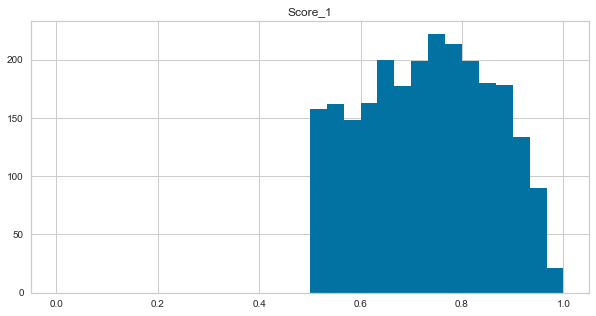

In [27]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

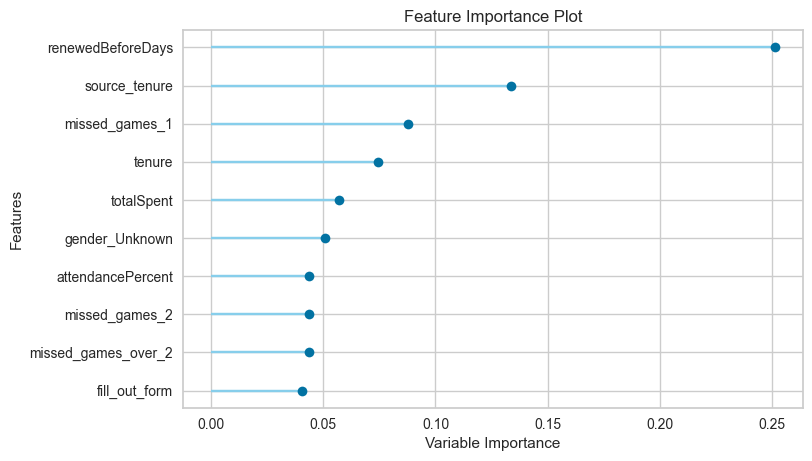

In [28]:
plot_model(best_model, plot='feature')

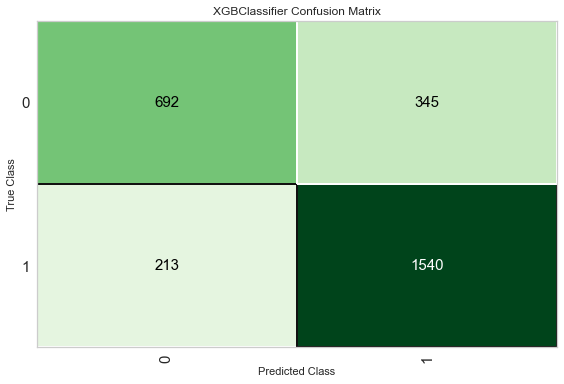

In [30]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?